In [1]:
%matplotlib inline

#import malariagen_data
import allel
import malariagen_data
import numpy as np
import pandas as pd
import seaborn as sns

# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe

In [3]:
inversionDict = {"2La" : ("2L", "karyotype/2La_targets.txt"),
                 "2Rj" : ("2R", "karyotype/2Rj_targets.txt"),
                 "2Rb" : ("2R", "karyotype/2Rb_targets.txt"),
                 "2Rc_col" : ("2R", "karyotype/2Rc_col_targets.txt"),
                 "2Rc_gam" : ("2R", "karyotype/2Rc_gam_targets.txt"),
                 "2Rd" : ("2R", "karyotype/2Rd_targets.txt"),
                 "2Ru" : ("2R", "karyotype/2Ru_targets.txt")}


def import_inversion(inversion):
    '''Load the tag '''
    path = inversionDict[inversion][1]
    targets = pd.read_csv(path, header=None).rename(columns={0:'pos'})    
    return targets

def calculate_genotype_at_concordant_sites(callset, targets, haps=False):
    '''Calculate the average number of alternate alleles for each specimen at
    each tag SNP.'''

    bool_ =  np.isin(callset['pos'], targets['pos'])
    genos = callset["geno"].compress(bool_, axis=0)
    if haps == False:
        alt_count = genos.to_n_alt()
    else:
        alt_count = genos
    is_called = genos.is_called()

    av_gts = np.mean(np.ma.MaskedArray(alt_count,
                                       mask=~is_called), axis=0).data
    match_dict = {0: None, 1: None, 2: None}

    for value in [0, 1, 2]:
        n_matches = np.sum(np.ma.MaskedArray(alt_count,
                                             mask=~is_called) == value,
                            axis=0).data
        match_dict[value] = n_matches

    total_sites = np.sum(is_called, axis=0)

    return av_gts, total_sites, match_dict[0], match_dict[1], match_dict[2]
    

def compkaryo(callset, inversion, haps=False):
    '''Extract tag SNPs and desired specimens and calculate the average
    number of alternate alleles.'''

    targets = import_inversion(inversion)

    av_gts, total_sites, num_0, num_1, num_2 = calculate_genotype_at_concordant_sites(callset, targets, haps)

    return av_gts, total_sites, num_0, num_1, num_2
   

### Karyotyping the GAARDIAN and Ag1000g data

In [4]:
ag3 = malariagen_data.Ag3(pre=True)

## compkaryo

In [12]:
my_sample_set  = [
    # Ag1000G phase 3 Ghana sample set in Ag3.0
    "AG1000G-GH",
    # GAARD Ghana sample set in Ag3.2
    #"1244-VO-GH-YAWSON-VMF00051",
    # Amenta-Etego sample sets in Ag3.3
    #'1190-VO-GH-AMENGA-ETEGO-VMF00013',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00014',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00028',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00029',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00046',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00047',
    # GAARDIAN sample set in Ag3.4
    #'1244-VO-GH-YAWSON-VMF00149',
    #'AG1000G-ML-A',
    #'AG1000G-BF-A',
    #'AG1000G-BF-B',
    #'AG1000G-GN-A',
    #'AG1000G-GN-B',
    #'1245-VO-CI-CONSTANT-VMF00054',
    #'1253-VO-TG-DJOGBENOU-VMF00052',
    #'1237-VO-BJ-DJOGBENOU-VMF00050'
]

dataset = 'DRC'


In [13]:
### 2La, 2Rb, 2Rc
metadata = ag3.sample_metadata(sample_sets=my_sample_set)


invDict = {}

for inversion in inversionDict.keys():
    contig = inversionDict[inversion][0]
    print(f"running {inversion}....")

    snps = ag3.snp_genotypes(region=contig, sample_sets=my_sample_set)
    pos = ag3.snp_sites(region=contig, field='POS')
    targets = pd.read_csv(f"karyotype/{inversion}_targets.txt", sep="\t", header=None)
    pos_inv = targets[0].to_list()
    pos = allel.SortedIndex(pos)
    pos_bool = pos.locate_intersection(pos_inv)[0]
    pos = pos[pos_bool]
    geno = allel.GenotypeDaskArray(snps).compress(pos_bool, axis=0)#

    callset = {'geno':geno, 'pos':pos, 'chrom':contig}
    print(f"--- Running CompKaryo {inversion}--- ")
    av_gts, total_sites, num_0, num_1, num_2 = compkaryo(callset, inversion, haps=False)
    invDict[inversion] = pd.DataFrame({'partner_sample_id': metadata['sample_id'], 
                            'inversion':inversion, 
                            'mean_genotype': av_gts, 
                            'total_snp_tags':total_sites})


karyotypes = pd.concat(invDict)
karyotypes.to_csv(f"results/{dataset}_karyotypes.tsv", sep="\t")


running 2La....
--- Running CompKaryo 2La--- 
running 2Rj....
--- Running CompKaryo 2Rj--- 
running 2Rb....
--- Running CompKaryo 2Rb--- 
running 2Rc_col....
--- Running CompKaryo 2Rc_col--- 


KeyboardInterrupt: 

In [8]:
chrom = '2L'

callset = {'geno':geno, 'pos':pos, 'chrom':chrom}
print(f"--- Running CompKaryo {inversion}--- ")
av_gts, total_sites, num_0, num_1, num_2 = compkaryo(callset, inversion, haps=False)
df = pd.DataFrame({'partner_sample_id': metadata['sample_id'], 
                        'inversion':inversion, 
                        'mean_genotype': av_gts, 
                        'total_snp_tags':total_sites})


--- Running CompKaryo 2La--- 


In [10]:
df

,partner_sample_id,inversion,mean_genotype,total_snp_tags
0,AA0052-C,2La,1.985577,208
1,AA0103-C,2La,0.000000,209
2,AA0115-C,2La,2.000000,208
3,AA0050-C,2La,2.000000,209
4,AA0134-C,2La,1.000000,209
...,...,...,...,...
95,AA0135-C,2La,1.000000,209
96,AA0124-C,2La,0.004785,209
97,AA0045-C,2La,0.009569,209
98,AA0072-C,2La,1.995215,209


<AxesSubplot:>

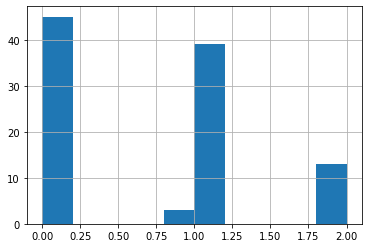

In [9]:
pd.Series(av_gts).hist()

In [33]:
df.to_csv("../../results/gaard_and_ag3.2la.karyo.tsv", sep="\t")